In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import r2_score
import random

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline

In [3]:
from spot import bidSPOT,dSPOT,SPOT

In [4]:
CV = 5

100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 3054.13it/s]

3507
Initial threshold : {'up': 0.02214744435000001, 'down': -0.02149985523000001}
Number of peaks : {'up': 3, 'down': 4}
Grimshaw maximum log-likelihood estimation ... [done]
	          Parameters               Upper               Lower
	------------------------------------------------------------
	                   γ               -0.25               -0.08
	                   σ                0.00                0.01
	          likelihood               18.09               13.71
	    Extreme quantile                0.02               -0.03
	------------------------------------------------------------


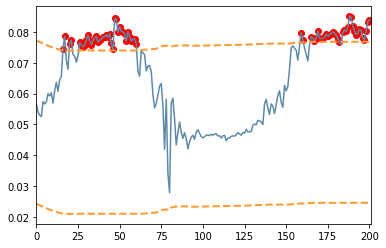

In [7]:
########### Rotational X


########detect extreme values with bidSPOT


df = pd.read_csv('data_triangleconfig/pitch7_triangle_processed.csv',sep=',')


# df = pd.read_csv(filename, sep=',')
print(df.size)
# df = pd.read_csv('data/nonrigid_rollall_processed.csv', sep=',')
df = df.dropna()
# print(df)

X = df.iloc[:, 0]
# X = df.dropna()
X = pd.to_numeric(X, errors='coerce')
X = X.values




n_init = 300


init_datax = X[:n_init] 	# initial batch
datax = X[n_init:]  		# stream

q = 1e-2 				# risk parameter
d = 100  # depth parameter
s = bidSPOT(q,d)     	# biDSPOT object
s.fit(init_datax,datax) 	# data import
s.initialize() 	  		# initialization step
xresults = s.run()    	# run
s.plot(xresults) 	 	# plot
plt.show()


In [5]:
# get total length of original  data

originalx = dfx.iloc[n_init:,:].copy()
# restart index
originalx = originalx.reset_index(drop='True')
total_lenx = originalx.shape[0]

####set data length training set 80% and testing 20%
testing_percentage=1/float(CV)
test_data_lenx = int(total_lenx*testing_percentage)
train_data_lenx = total_lenx - test_data_lenx
total_lenx
test_data_lenx

1028

In [6]:
r_2_list = []
vis_prediction = []
vis_gap = []
normal_event_idx = np.setdiff1d(range(total_lenx),xresults['alarms'])

In [7]:
#split dataset into training and testing datasets

list_training=[]
list_testing=[]
for i in range(CV):
    dfx_backup = dfx.iloc[n_init:,:].copy()
    dfx_backup =dfx_backup.reset_index(drop='True')
    # decide where to make holes
    count = 0
    print("currently dealing with loop:", i)
    
    testing_startx = test_data_lenx * i
    testing_endx = testing_startx + test_data_lenx
    testing_datax = dfx_backup.iloc[testing_startx:testing_endx]
    

    
    if i == 0:
        training_datax = dfx_backup.iloc[testing_endx:]
    elif i<4:
        training_data_firstx = dfx_backup.iloc[:testing_startx]
        training_data_secondx = dfx_backup.iloc[testing_endx:]
        training_datax = pd.concat([training_data_firstx,training_data_secondx])
    else:
        training_datax = dfx_backup.iloc[:testing_startx]

    #list_training.append(training_datax)
    #list_testing.append(testing_datax)

#list_training
#list_testing

currently dealing with loop: 0
currently dealing with loop: 1
currently dealing with loop: 2
currently dealing with loop: 3
currently dealing with loop: 4


In [8]:
##training_datax1=list_training[0]
#training_datax1

#testing_datax1=list_testing[0]
# testing_datax1

In [9]:
# split the training data into normal and extreme sets
flag_array_extremex = np.array([m for m in xresults['alarms'] if m<testing_startx or m>testing_endx])  
extreme_trainingx = training_datax.loc[flag_array_extremex]
flag_array_normalx = np.array([m for m in normal_event_idx if m<testing_startx or m>testing_endx])  
normal_trainingx = training_datax.loc[flag_array_normalx]

In [16]:
# set kernels
decisiontree_extreme = DecisionTreeRegressor(max_features='sqrt')
decisiontree_normal = DecisionTreeRegressor(max_features='sqrt')

knn_extreme= KNeighborsRegressor(n_neighbors=3)
knn_normal= KNeighborsRegressor(n_neighbors=3)

mlp_extreme = MLPRegressor(learning_rate='adaptive', max_iter=500)
mlp_normal = MLPRegressor(learning_rate='adaptive', max_iter=500)

gbr_extreme= GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100,
       subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
       min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None,
       init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, 
       warm_start=False, validation_fraction=0.1, tol=0.0001)

gbr_normal = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100,
       subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
       min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None,
       init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, 
       warm_start=False, validation_fraction=0.1, tol=0.0001)





In [17]:
# train the model with kernal gbr

gbr_extreme.fit(extreme_trainingx.iloc[:,1:6].values,extreme_trainingx.iloc[:,0].values) 
gbr_normal.fit(normal_trainingx.iloc[:,1:6].values,normal_trainingx.iloc[:,0].values)


# testing
testing_datax_f = testing_datax.iloc[:,1:6].values
testing_datax_x = testing_datax.iloc[:,0].values


xpredictions = []
for count in range(len(testing_datax_x)):
	record_index = testing_startx+count
	if record_index in xresults['alarms']:
		# extreme event
		tmp_pred = gbr_extreme.predict([testing_datax_f[count]])
	else:
	# normal event
	    tmp_pred = gbr_normal.predict([testing_datax_f[count]])
	xpredictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_datax_x, xpredictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

current is cv fold 4 r^2 value is 0.989758150405772
avg_r2 is: 0.99023802340611


In [18]:
 
# train the model with kernal  knn

knn_extreme.fit(extreme_trainingx.iloc[:,1:6].values,extreme_trainingx.iloc[:,0].values) 
knn_normal.fit(normal_trainingx.iloc[:,1:6].values,normal_trainingx.iloc[:,0].values)


# testing
testing_datax_f = testing_datax.iloc[:,1:6].values
testing_datax_x = testing_datax.iloc[:,0].values


xpredictions = []
for count in range(len(testing_datax_x)):
	record_index = testing_startx+count
	if record_index in xresults['alarms']:
		# extreme event
		tmp_pred = knn_extreme.predict([testing_datax_f[count]])
	else:
	# normal event
	    tmp_pred = knn_normal.predict([testing_datax_f[count]])
	xpredictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_datax_x, xpredictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

current is cv fold 4 r^2 value is 0.9846199519334689
avg_r2 is: 0.9891144091115818


In [19]:
 
# train the model with kernal  mlp

mlp_extreme.fit(extreme_trainingx.iloc[:,1:6].values,extreme_trainingx.iloc[:,0].values) 
mlp_normal.fit(normal_trainingx.iloc[:,1:6].values,normal_trainingx.iloc[:,0].values)


# testing
testing_datax_f = testing_datax.iloc[:,1:6].values
testing_datax_x = testing_datax.iloc[:,0].values


xpredictions = []
for count in range(len(testing_datax_x)):
	record_index = testing_startx+count
	if record_index in xresults['alarms']:
		# extreme event
		tmp_pred = mlp_extreme.predict([testing_datax_f[count]])
	else:
	# normal event
	    tmp_pred = mlp_normal.predict([testing_datax_f[count]])
	xpredictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_datax_x, xpredictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))



current is cv fold 4 r^2 value is 0.9982667240909378
avg_r2 is: 0.9906397949414744


In [20]:
 
# train the model with kernal  decision tree

decisiontree_extreme.fit(extreme_trainingx.iloc[:,1:6].values,extreme_trainingx.iloc[:,0].values) 
decisiontree_normal.fit(normal_trainingx.iloc[:,1:6].values,normal_trainingx.iloc[:,0].values)


# testing
testing_datax_f = testing_datax.iloc[:,1:6].values
testing_datax_x = testing_datax.iloc[:,0].values


xpredictions = []
for count in range(len(testing_datax_x)):
	record_index = testing_startx+count
	if record_index in xresults['alarms']:
		# extreme event
		tmp_pred = decisiontree_extreme.predict([testing_datax_f[count]])
	else:
	# normal event
	    tmp_pred = decisiontree_normal.predict([testing_datax_f[count]])
	xpredictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_datax_x, xpredictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

current is cv fold 4 r^2 value is 0.9867476698058418
avg_r2 is: 0.9900837770649555


  1%|█                                                                              | 70/5140 [00:00<00:16, 314.08it/s]

Initial threshold : {'up': 22.27960518019251, 'down': -22.357220444149988}
Number of peaks : {'up': 11, 'down': 12}
Grimshaw maximum log-likelihood estimation ... [done]
	          Parameters               Upper               Lower
	------------------------------------------------------------
	                   γ               -0.05               -0.07
	                   σ                0.31                0.27
	          likelihood                2.33                4.36
	    Extreme quantile               23.13              -23.10
	------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████| 5140/5140 [00:01<00:00, 5101.18it/s]


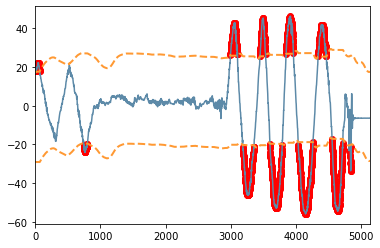

In [21]:
########### Rotational Y


########detect extreme values with bidSPOT


dfy = pd.read_csv('data/RotationalY_flag.csv',sep=',')


Xy = dfy['y'].to_numpy(dtype='float')
Xy_backup = Xy.copy()




n_init = 1000


init_datay = Xy[:n_init] 	# initial batch
datay = Xy[n_init:]  		# stream

q = 1e-3 				# risk parameter
d = 400  # depth parameter
s = bidSPOT(q,d)     	# biDSPOT object
s.fit(init_datay,datay) 	# data import
s.initialize() 	  		# initialization step
yresults = s.run()    	# run
s.plot(yresults) 	 	# plot
plt.show()


In [22]:
# get total length of original  data

originaly= dfy.iloc[n_init:,:].copy()
# restart index
originaly = originaly.reset_index(drop='True')
total_leny = originaly.shape[0]

####set data length training set 80% and testing 20%
testing_percentage=1/float(CV)
test_data_leny = int(total_leny*testing_percentage)
train_data_leny = total_leny - test_data_leny
total_leny
test_data_leny

1028

In [23]:
r_2_listy = []
vis_prediction = []
vis_gap = []
normal_event_idy = np.setdiff1d(range(total_leny),yresults['alarms'])

In [24]:
#split dataset into training and testing datasets



for i in range(CV):
	dfy_backup = dfy.iloc[n_init:,:].copy()
	dfy_backup =dfy_backup.reset_index(drop='True')
	# decide where to make holes
	count = 0
	print("currently dealing with loop:", i)

	testing_starty = test_data_leny * i
	testing_endy = testing_starty + test_data_leny
	testing_datay = dfy_backup.iloc[testing_starty:testing_endy]

	if i == 0:
		training_datay = dfy_backup.iloc[testing_endy:]
	elif i<4:
		training_data_firsty = dfy_backup.iloc[:testing_starty]
		training_data_secondy = dfy_backup.iloc[testing_endy:]
		training_datay = pd.concat([training_data_firsty,training_data_secondy])
	else:
		training_datay = dfy_backup.iloc[:testing_starty]



currently dealing with loop: 0
currently dealing with loop: 1
currently dealing with loop: 2
currently dealing with loop: 3
currently dealing with loop: 4


In [25]:
# split the training data into normal and extreme sets
flag_array_extremey = np.array([m for m in yresults['alarms'] if m<testing_starty or m>testing_endy])  
extreme_trainingy = training_datay.loc[flag_array_extremey]
flag_array_normaly = np.array([m for m in normal_event_idy if m<testing_starty or m>testing_endy])  
normal_trainingy = training_datay.loc[flag_array_normaly]

In [26]:
# train the model with kernal gbr

gbr_extreme.fit(extreme_trainingy.iloc[:,1:6].values,extreme_trainingy.iloc[:,0].values) 
gbr_normal.fit(normal_trainingy.iloc[:,1:6].values,normal_trainingy.iloc[:,0].values)


# testing
testing_datay_f = testing_datay.iloc[:,1:6].values
testing_datay_y = testing_datay.iloc[:,0].values


ypredictions = []
for count in range(len(testing_datay_y)):
	record_index = testing_starty+count
	if record_index in yresults['alarms']:
		# extreme event
		tmp_pred = gbr_extreme.predict([testing_datay_f[count]])
	else:
	# normal event
	    tmp_pred = gbr_normal.predict([testing_datay_f[count]])
	ypredictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_datay_y, ypredictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

current is cv fold 4 r^2 value is 0.9980264423017974
avg_r2 is: 0.9910766102195607


In [27]:
# train the model with kernal knn

knn_extreme.fit(extreme_trainingy.iloc[:,1:6].values,extreme_trainingy.iloc[:,0].values) 
knn_normal.fit(normal_trainingy.iloc[:,1:6].values,normal_trainingy.iloc[:,0].values)


# testing
testing_datay_f = testing_datay.iloc[:,1:6].values
testing_datay_y = testing_datay.iloc[:,0].values


ypredictions = []
for count in range(len(testing_datay_y)):
	record_index = testing_starty+count
	if record_index in yresults['alarms']:
		# extreme event
		tmp_pred = knn_extreme.predict([testing_datay_f[count]])
	else:
	# normal event
	    tmp_pred = knn_normal.predict([testing_datay_f[count]])
	ypredictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_datay_y, ypredictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

current is cv fold 4 r^2 value is 0.989792378880452
avg_r2 is: 0.9909339178485487


In [28]:
# train the model with kernal decision tree

decisiontree_extreme.fit(extreme_trainingy.iloc[:,1:6].values,extreme_trainingy.iloc[:,0].values) 
decisiontree_normal.fit(normal_trainingy.iloc[:,1:6].values,normal_trainingy.iloc[:,0].values)


# testing
testing_datay_f = testing_datay.iloc[:,1:6].values
testing_datay_y = testing_datay.iloc[:,0].values


ypredictions = []
for count in range(len(testing_datay_y)):
	record_index = testing_starty+count
	if record_index in yresults['alarms']:
		# extreme event
		tmp_pred = decisiontree_extreme.predict([testing_datay_f[count]])
	else:
	# normal event
	    tmp_pred = decisiontree_normal.predict([testing_datay_f[count]])
	ypredictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_datay_y, ypredictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

current is cv fold 4 r^2 value is 0.9965463013504469
avg_r2 is: 0.9914951561987385


In [29]:
# train the model with kernal mlp

mlp_extreme.fit(extreme_trainingy.iloc[:,1:6].values,extreme_trainingy.iloc[:,0].values) 
mlp_normal.fit(normal_trainingy.iloc[:,1:6].values,normal_trainingy.iloc[:,0].values)


# testing
testing_datay_f = testing_datay.iloc[:,1:6].values
testing_datay_y = testing_datay.iloc[:,0].values


ypredictions = []
for count in range(len(testing_datay_y)):
	record_index = testing_starty+count
	if record_index in yresults['alarms']:
		# extreme event
		tmp_pred = gbr_extreme.predict([testing_datay_f[count]])
	else:
	# normal event
	    tmp_pred = gbr_normal.predict([testing_datay_f[count]])
	ypredictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_datay_y, ypredictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

current is cv fold 4 r^2 value is 0.9980264423017974
avg_r2 is: 0.9920889094808348


  0%|                                                                                 | 2/4140 [00:00<03:30, 19.64it/s]

Initial threshold : {'up': 9.02276223771996, 'down': -13.191928528640247}
Number of peaks : {'up': 19, 'down': 20}
Grimshaw maximum log-likelihood estimation ... [done]
	          Parameters               Upper               Lower
	------------------------------------------------------------
	                   γ                0.00                0.00
	                   σ                0.84                3.59
	          likelihood               15.59               45.54
	    Extreme quantile               11.48              -23.94
	------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████| 4140/4140 [00:22<00:00, 185.72it/s]


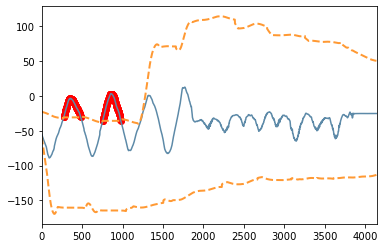

In [30]:
########### Rotational Z


########detect extreme values with bidSPOT


dfz = pd.read_csv('data/RotationalZ.csv',sep=',')


Xz = dfz['z'].to_numpy(dtype='float')
Xz_backup = Xz.copy()




n_init = 2000


init_dataz = Xz[:n_init] 	# initial batch
dataz = Xz[n_init:]  		# stream

q = 1e-3 				# risk parameter
d =  1000 #depth parameter
s = bidSPOT(q,d)     	# biDSPOT object
s.fit(init_dataz,dataz) 	# data import
s.initialize() 	  		# initialization step
zresults = s.run()    	# run
s.plot(zresults) 	 	# plot
plt.show()

In [31]:
# get total length of original  data

originalz= dfz.iloc[n_init:,:].copy()
# restart index
originalz = originalz.reset_index(drop='True')
total_lenz = originalz.shape[0]

####set data length training set 80% and testing 20%
testing_percentage=1/float(CV)
test_data_lenz = int(total_lenz*testing_percentage)
train_data_lenz = total_lenz - test_data_lenz
total_lenz
test_data_lenz

828

In [32]:
r_2_list = []
vis_prediction = []
vis_gap = []
normal_event_idz= np.setdiff1d(range(total_lenz),zresults['alarms'])

In [33]:
#split dataset into training and testing datasets

list_training=[]
list_testing=[]
for i in range(CV):
    dfz_backup = dfz.iloc[n_init:,:].copy()
    dfz_backup =dfz_backup.reset_index(drop='True')
    # decide where to make holes
    count = 0
    print("currently dealing with loop:", i)
    
    testing_startz = test_data_lenx * i
    testing_endz = testing_startz + test_data_lenz
    testing_dataz = dfz_backup.iloc[testing_startz:testing_endz]
    

    
    if i == 0:
        training_dataz = dfz_backup.iloc[testing_endz:]
    elif i<4:
        training_data_firstz = dfz_backup.iloc[:testing_startz]
        training_data_secondz = dfz_backup.iloc[testing_endz:]
        training_dataz = pd.concat([training_data_firstz,training_data_secondz])
    else:
        training_dataz = dfz_backup.iloc[:testing_startz]

currently dealing with loop: 0
currently dealing with loop: 1
currently dealing with loop: 2
currently dealing with loop: 3
currently dealing with loop: 4


In [34]:
flag_array_extremez = np.array([m for m in zresults['alarms'] if m<testing_startz or m>testing_endz])  
extreme_trainingz = training_dataz.loc[flag_array_extremez]
flag_array_normalz = np.array([m for m in normal_event_idz if m<testing_startz or m>testing_endz])  
normal_trainingz = training_dataz.loc[flag_array_normalz]

In [35]:
# train the model with kernal gbr

gbr_extreme.fit(extreme_trainingz.iloc[:,1:6].values,extreme_trainingz.iloc[:,0].values) 
gbr_normal.fit(normal_trainingz.iloc[:,1:6].values,normal_trainingz.iloc[:,0].values)


# testing
testing_dataz_f = testing_dataz.iloc[:,1:6].values
testing_dataz_z = testing_dataz.iloc[:,0].values


predictions = []
for count in range(len(testing_dataz_z)):
	record_index = testing_startz+count
	if record_index in zresults['alarms']:
		# extreme event
		tmp_pred = gbr_extreme.predict([testing_dataz_f[count]])
	else:
	# normal event
	    tmp_pred = gbr_normal.predict([testing_dataz_f[count]])
	predictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_dataz_z, predictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

current is cv fold 4 r^2 value is -2.0369592918007826
avg_r2 is: -2.0369592918007826


In [36]:
# train the model with kernal knn

knn_extreme.fit(extreme_trainingz.iloc[:,1:6].values,extreme_trainingz.iloc[:,0].values) 
knn_normal.fit(normal_trainingz.iloc[:,1:6].values,normal_trainingz.iloc[:,0].values)


# testing
testing_dataz_f = testing_dataz.iloc[:,1:6].values
testing_dataz_z = testing_dataz.iloc[:,0].values


predictions = []
for count in range(len(testing_dataz_z)):
	record_index = testing_startz+count
	if record_index in zresults['alarms']:
		# extreme event
		tmp_pred = knn_extreme.predict([testing_dataz_f[count]])
	else:
	# normal event
	    tmp_pred = knn_normal.predict([testing_dataz_f[count]])
	predictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_dataz_z, predictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

current is cv fold 4 r^2 value is -0.6641440398299328
avg_r2 is: -1.3505516658153578


In [37]:
# train the model with kernal decision tree

decisiontree_extreme.fit(extreme_trainingz.iloc[:,1:6].values,extreme_trainingz.iloc[:,0].values) 
decisiontree_normal.fit(normal_trainingz.iloc[:,1:6].values,normal_trainingz.iloc[:,0].values)


# testing
testing_dataz_f = testing_dataz.iloc[:,1:6].values
testing_dataz_z = testing_dataz.iloc[:,0].values


predictions = []
for count in range(len(testing_dataz_z)):
	record_index = testing_startz+count
	if record_index in zresults['alarms']:
		# extreme event
		tmp_pred = decisiontree_extreme.predict([testing_dataz_f[count]])
	else:
	# normal event
	    tmp_pred = decisiontree_normal.predict([testing_dataz_f[count]])
	predictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_dataz_z, predictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

current is cv fold 4 r^2 value is -0.03197061222613118
avg_r2 is: -0.9110246479522823


In [38]:
# train the model with kernal  mlp

mlp_extreme.fit(extreme_trainingz.iloc[:,1:6].values,extreme_trainingz.iloc[:,0].values) 
mlp_normal.fit(normal_trainingz.iloc[:,1:6].values,normal_trainingz.iloc[:,0].values)


# testing
testing_dataz_f = testing_dataz.iloc[:,1:6].values
testing_dataz_z = testing_dataz.iloc[:,0].values


predictions = []
for count in range(len(testing_dataz_z)):
	record_index = testing_startz+count
	if record_index in zresults['alarms']:
		# extreme event
		tmp_pred = mlp_extreme.predict([testing_dataz_f[count]])
	else:
	# normal event
	    tmp_pred = mlp_normal.predict([testing_dataz_f[count]])
	predictions.append(tmp_pred)

tmp_r_2 = r2_score(testing_dataz_z, predictions)
r_2_list.append(tmp_r_2)
print("current is cv fold", i, "r^2 value is", tmp_r_2)

print("avg_r2 is:", sum(r_2_list) / len(r_2_list))

c:\users\wangp\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


current is cv fold 4 r^2 value is -1.6252392979428176
avg_r2 is: -1.0895783104499162
